# Well Workover Portfolio Optimization using Linear Programming
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Probabilistic Simulation and Cash Flow

## 1. Introduction
In this notebook, we act as a Production Engineer who has a list of **15 candidate wells** for various workover jobs (Acidizing, Fracking, Pump changes, etc.). 

We have a fixed budget of **$300,000**.
Our goal is to choose the best combination of wells to **maximize oil production** without breaking the bank.

## 2. Methodology
We will use:
1.  **Pandas**: For data manipulation.
2.  **PuLP**: A python library for Linear Programming to solve the optimization problem.
3.  **Matplotlib/Seaborn**: For visualizing the selected portfolio vs. unselected candidates.

In [2]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt
import seaborn as sns

# Display configuration
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

## 3. Load Data
Let's load our candidate list. Each row represents a project with an `Estimated_Cost_USD` and an `Estimated_Gain_BOPD` (Barrels of Oil Per Day).

Total Candidates: 15


,Well_ID,Workover_Type,Estimated_Cost_USD,Estimated_Gain_BOPD
0,Well-001,Acid Stimulation,15000,25
1,Well-002,Pump Replacement,45000,60
2,Well-003,Hydraulic Frac,120000,150
3,Well-004,Zone Isolation,30000,35
4,Well-005,Scale Removal,10000,15


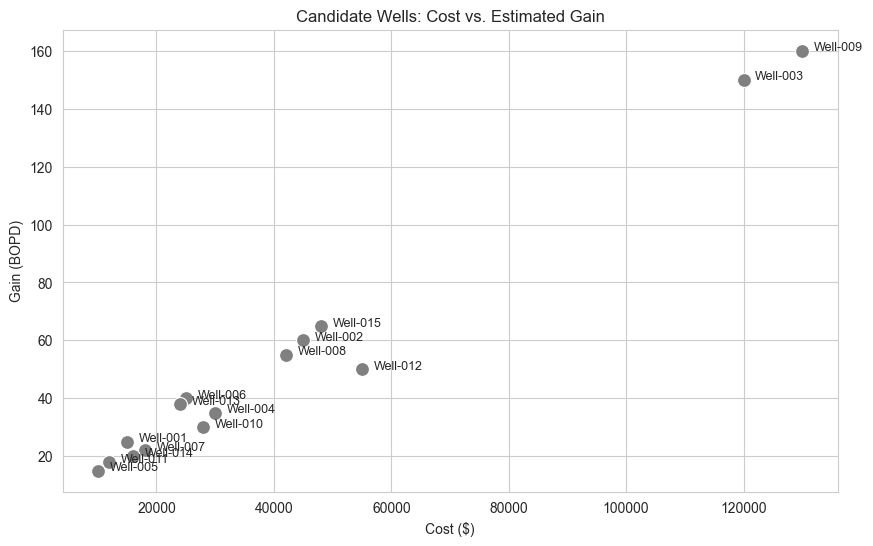

In [3]:
# Load the dataset
df = pd.read_csv('well_candidates.csv')

# Inspect the data
print(f"Total Candidates: {len(df)}")
display(df.head())

# Quick scatter plot of Cost vs Gain
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Estimated_Cost_USD', y='Estimated_Gain_BOPD', s=100, color='grey')
plt.title("Candidate Wells: Cost vs. Estimated Gain")
plt.xlabel("Cost ($)")
plt.ylabel("Gain (BOPD)")
for i in range(df.shape[0]):
    plt.text(df.Estimated_Cost_USD[i]+2000, df.Estimated_Gain_BOPD[i], df.Well_ID[i], fontsize=9)
plt.show()

## 4. Define the Optimization Problem

We will define the **LpProblem** using `PuLP`.

### Constraints
* **Budget:** $300,000 USD
* **Variable Type:** Binary (0 or 1). We cannot do "half" a workover. Either we do the job, or we don't.

In [4]:
# 1. Initialize the Model
# LpMaximize because we want to maximize Production
prob = pulp.LpProblem("Workover_Portfolio_Optimization", pulp.LpMaximize)

# 2. Define Decision Variables
# We create a dictionary of binary variables, one for each row index in our dataframe
# cat='Binary' ensures the variable can only be 0 or 1
well_indices = df.index.tolist()
selection_vars = pulp.LpVariable.dicts("Select", well_indices, cat='Binary')

# 3. Define the Objective Function
# Sum of (Gain * Selection_Variable) for all wells
prob += pulp.lpSum([df.loc[i, 'Estimated_Gain_BOPD'] * selection_vars[i] for i in well_indices]), "Total_Production_Gain"

# 4. Define the Budget Constraint
# Sum of (Cost * Selection_Variable) <= Total Budget
TOTAL_BUDGET = 300000

prob += pulp.lpSum([df.loc[i, 'Estimated_Cost_USD'] * selection_vars[i] for i in well_indices]) <= TOTAL_BUDGET, "Budget_Constraint"

# Check the problem setup
print("Problem definition:")
print(prob)

Problem definition:
Workover_Portfolio_Optimization:
MAXIMIZE
25*Select_0 + 60*Select_1 + 18*Select_10 + 50*Select_11 + 38*Select_12 + 20*Select_13 + 65*Select_14 + 150*Select_2 + 35*Select_3 + 15*Select_4 + 40*Select_5 + 22*Select_6 + 55*Select_7 + 160*Select_8 + 30*Select_9 + 0.0
SUBJECT TO
Budget_Constraint: 15000 Select_0 + 45000 Select_1 + 12000 Select_10
 + 55000 Select_11 + 24000 Select_12 + 16000 Select_13 + 48000 Select_14
 + 120000 Select_2 + 30000 Select_3 + 10000 Select_4 + 25000 Select_5
 + 18000 Select_6 + 42000 Select_7 + 130000 Select_8 + 28000 Select_9
 <= 300000

VARIABLES
0 <= Select_0 <= 1 Integer
0 <= Select_1 <= 1 Integer
0 <= Select_10 <= 1 Integer
0 <= Select_11 <= 1 Integer
0 <= Select_12 <= 1 Integer
0 <= Select_13 <= 1 Integer
0 <= Select_14 <= 1 Integer
0 <= Select_2 <= 1 Integer
0 <= Select_3 <= 1 Integer
0 <= Select_4 <= 1 Integer
0 <= Select_5 <= 1 Integer
0 <= Select_6 <= 1 Integer
0 <= Select_7 <= 1 Integer
0 <= Select_8 <= 1 Integer
0 <= Select_9 <= 1 

## 5. Solve the Problem
We invoke the solver. PuLP will try to find the combination of `1`s and `0`s that maximizes the objective function while respecting the constraint.

In [5]:
# Solve
status = prob.solve()

# Print Status
print(f"Status: {pulp.LpStatus[status]}")

# Print Total Calculated Objective
print(f"Total Optimized Production Gain: {pulp.value(prob.objective)} BOPD")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ad34412a22fc4d1e9f4ea6885ab046f4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ad34412a22fc4d1e9f4ea6885ab046f4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 67 RHS
At line 69 BOUNDS
At line 85 ENDATA
Problem MODEL has 1 rows, 15 columns and 15 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 414.75 - 0.00 seconds
Cgl0004I processed model has 1 rows, 15 columns (15 integer (15 of which binary)) and 15 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.475
Cbc0038I Pa

## 6. Analyze Results
We will map the binary results back to our original DataFrame to see which wells were selected.

In [6]:
# Extract results
results = []
for i in well_indices:
    results.append(int(selection_vars[i].varValue))

# Add 'Selected' column to dataframe
df['Selected'] = results

# Filter to show only selected projects
selected_portfolio = df[df['Selected'] == 1]
rejected_portfolio = df[df['Selected'] == 0]

# Calculate totals
total_cost = selected_portfolio['Estimated_Cost_USD'].sum()
total_gain = selected_portfolio['Estimated_Gain_BOPD'].sum()
well_count = len(selected_portfolio)

print("--- Optimization Summary ---")
print(f"Budget Limit:   ${TOTAL_BUDGET:,.0f}")
print(f"Actual Spent:   ${total_cost:,.0f}")
print(f"Remaining:      ${TOTAL_BUDGET - total_cost:,.0f}")
print(f"Total Gain:     {total_gain} BOPD")
print(f"Wells Selected: {well_count}")

display(selected_portfolio.sort_values(by='Estimated_Gain_BOPD', ascending=False))

--- Optimization Summary ---
Budget Limit:   $300,000
Actual Spent:   $299,000
Remaining:      $1,000
Total Gain:     411 BOPD
Wells Selected: 8


,Well_ID,Workover_Type,Estimated_Cost_USD,Estimated_Gain_BOPD,Selected
2,Well-003,Hydraulic Frac,120000,150,1
14,Well-015,Pump Replacement,48000,65,1
1,Well-002,Pump Replacement,45000,60,1
5,Well-006,Re-perforation,25000,40,1
12,Well-013,Re-perforation,24000,38,1
0,Well-001,Acid Stimulation,15000,25,1
10,Well-011,Scale Removal,12000,18,1
4,Well-005,Scale Removal,10000,15,1


## 7. Visualization
Let's visualize the Selected vs. Rejected wells. You will notice that the solver didn't just pick the cheapest wells, nor did it just pick the highest gain wells. It picked the **most efficient mix** to fill the budget jar.

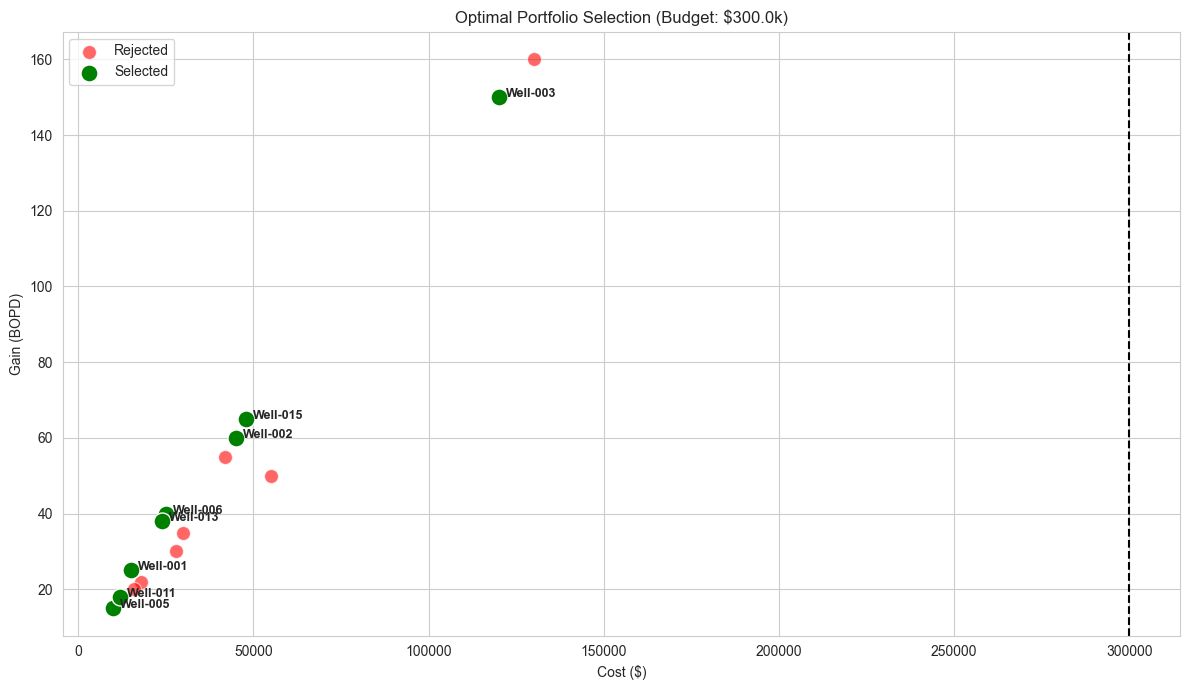

In [7]:
plt.figure(figsize=(12, 7))

# Plot Rejected
sns.scatterplot(
    data=rejected_portfolio, 
    x='Estimated_Cost_USD', 
    y='Estimated_Gain_BOPD', 
    color='red', 
    label='Rejected', 
    s=100,
    alpha=0.6
)

# Plot Selected
sns.scatterplot(
    data=selected_portfolio, 
    x='Estimated_Cost_USD', 
    y='Estimated_Gain_BOPD', 
    color='green', 
    label='Selected', 
    s=150
)

# Annotations
for i in df.index:
    if df.loc[i, 'Selected'] == 1:
        plt.text(df.loc[i, 'Estimated_Cost_USD']+2000, df.loc[i, 'Estimated_Gain_BOPD'], df.loc[i, 'Well_ID'], fontsize=9, fontweight='bold')

plt.title(f"Optimal Portfolio Selection (Budget: ${TOTAL_BUDGET/1000}k)")
plt.xlabel("Cost ($)")
plt.ylabel("Gain (BOPD)")
plt.legend()
plt.axvline(x=TOTAL_BUDGET, color='black', linestyle='--', label='Total Budget (Scale)')

plt.tight_layout()
plt.show()